In [1]:
!pip install torch torchvision matplotlib numpy

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [12]:
class DigitRecognizer(nn.Module):
    def __init__(self):
        super(DigitRecognizer, self).__init__()
        self.flatten = nn.Flatten()
        self.network = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    
    def forward(self, x):
        x = self.flatten(x)
        return self.network(x)

In [13]:
def load_data(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_data = datasets.MNIST(
        root='./data', train=True, download=True, transform=transform
    )
    test_data = datasets.MNIST(
        root='./data', train=False, download=True, transform=transform
    )
    
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

In [14]:
def train(model, train_loader, epochs=5, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    print(f"Training on {device}")
    print("-" * 40)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
        
        accuracy = 100. * correct / total
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.2f}%")
    
    return model

In [15]:

def evaluate(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    accuracy = 100. * correct / total
    print(f"\nTest Accuracy: {accuracy:.2f}%")
    return accuracy

In [16]:
def predict_digit(model, image):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    with torch.no_grad():
        image = image.to(device)
        if image.dim() == 3:
            image = image.unsqueeze(0)
        output = model(image)
        probabilities = torch.softmax(output, dim=1)
        predicted = output.argmax(dim=1).item()
        confidence = probabilities[0][predicted].item() * 100
    
    return predicted, confidence

In [17]:
def visualize_predictions(model, test_loader, num_samples=10):
    model.eval()
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    axes = axes.flatten()
    
    for i in range(num_samples):
        img = images[i]
        true_label = labels[i].item()
        pred, conf = predict_digit(model, img)
        
        axes[i].imshow(img.squeeze(), cmap='gray')
        color = 'green' if pred == true_label else 'red'
        axes[i].set_title(f"Pred: {pred} ({conf:.1f}%)\nTrue: {true_label}", color=color)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('predictions.png', dpi=150)
    plt.show()
    print("Predictions saved to 'predictions.png'")

In [18]:
def save_model(model, path='digit_recognizer.pth'):
    torch.save(model.state_dict(), path)
    print(f"Model saved to '{path}'")


In [19]:
def load_model(path='digit_recognizer.pth'):

    model = DigitRecognizer()
    model.load_state_dict(torch.load(path, weights_only=True))
    print(f"Model loaded from '{path}'")
    return model

Handwritten Digit Recognition

[1/4] Loading MNIST dataset...
Training samples: 60000
Test samples: 10000

[2/4] Creating neural network...
Model parameters: 567,434

[3/4] Training model...
Training on cpu
----------------------------------------
Training samples: 60000
Test samples: 10000

[2/4] Creating neural network...
Model parameters: 567,434

[3/4] Training model...
Training on cpu
----------------------------------------
Epoch 1/5 | Loss: 0.2572 | Accuracy: 91.93%
Epoch 1/5 | Loss: 0.2572 | Accuracy: 91.93%
Epoch 2/5 | Loss: 0.1208 | Accuracy: 96.36%
Epoch 2/5 | Loss: 0.1208 | Accuracy: 96.36%
Epoch 3/5 | Loss: 0.0960 | Accuracy: 97.14%
Epoch 3/5 | Loss: 0.0960 | Accuracy: 97.14%
Epoch 4/5 | Loss: 0.0774 | Accuracy: 97.59%
Epoch 4/5 | Loss: 0.0774 | Accuracy: 97.59%
Epoch 5/5 | Loss: 0.0671 | Accuracy: 97.95%

[4/4] Evaluating model...
Epoch 5/5 | Loss: 0.0671 | Accuracy: 97.95%

[4/4] Evaluating model...

Test Accuracy: 97.23%
Model saved to 'digit_recognizer.pth'

Generating

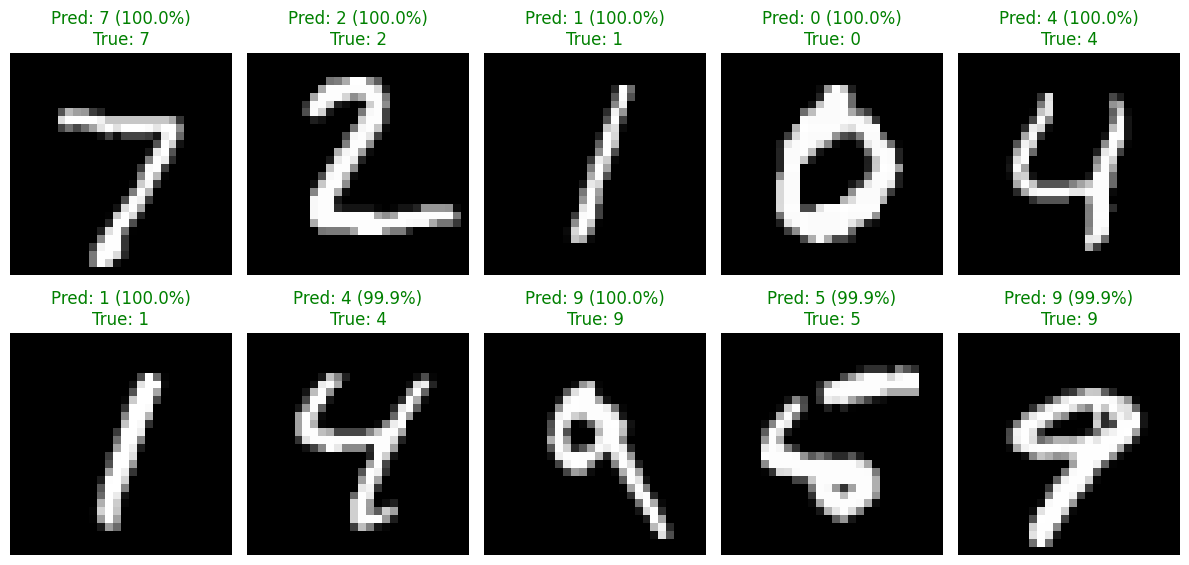

Predictions saved to 'predictions.png'


In [20]:
if __name__ == "__main__":
    print("=" * 40)
    print("Handwritten Digit Recognition")
    print("=" * 40)

    print("\n[1/4] Loading MNIST dataset...")
    train_loader, test_loader = load_data(batch_size=64)
    print(f"Training samples: {len(train_loader.dataset)}")
    print(f"Test samples: {len(test_loader.dataset)}")

    print("\n[2/4] Creating neural network...")
    model = DigitRecognizer()
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Model parameters: {total_params:,}")

    print("\n[3/4] Training model...")
    model = train(model, train_loader, epochs=5, lr=0.001)

    print("\n[4/4] Evaluating model...")
    evaluate(model, test_loader)

    save_model(model)

    print("\nGenerating prediction visualization...")
    visualize_predictions(model, test_loader)
    
    